In [70]:
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', None)

In [71]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

mpl.rc('font', size=BIGGER_SIZE)
mpl.rc('axes', titlesize=BIGGER_SIZE)

In [72]:
df =  pd.read_csv('csv/base.csv', sep=','  , engine='python')
print('Conteudo: ')
df

Conteudo: 


,NU_ANO_CENSO,CO_ENTIDADE,NO_ENTIDADE,CO_ORGAO_REGIONAL,TP_SITUACAO_FUNCIONAMENTO,CO_UF,CO_MICRORREGIAO,CO_MUNICIPIO,TP_DEPENDENCIA,TP_REGULAMENTACAO,IN_LOCAL_FUNC_PREDIO_ESCOLAR,IN_LOCAL_FUNC_SALAS_EMPRESA,IN_LOCAL_FUNC_SALAS_OUTRA_ESC,IN_LOCAL_FUNC_UNID_PRISIONAL,IN_LOCAL_FUNC_TEMPLO_IGREJA,IN_LOCAL_FUNC_CASA_PROFESSOR,IN_LOCAL_FUNC_GALPAO,IN_LOCAL_FUNC_OUTROS,IN_PREDIO_COMPARTILHADO,IN_AGUA_FILTRADA,IN_AGUA_REDE_PUBLICA,IN_AGUA_POCO_ARTESIANO,IN_AGUA_CACIMBA,IN_AGUA_FONTE_RIO,IN_AGUA_INEXISTENTE,IN_ENERGIA_REDE_PUBLICA,IN_ENERGIA_GERADOR,IN_ENERGIA_OUTROS,IN_ENERGIA_INEXISTENTE,IN_ESGOTO_REDE_PUBLICA,IN_ESGOTO_FOSSA,IN_ESGOTO_INEXISTENTE,IN_LIXO_COLETA_PERIODICA,IN_LIXO_QUEIMA,IN_LIXO_JOGA_OUTRA_AREA,IN_LIXO_RECICLA,IN_LIXO_ENTERRA,IN_LIXO_OUTROS,IN_SALA_DIRETORIA,IN_SALA_PROFESSOR,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_SALA_ATENDIMENTO_ESPECIAL,IN_QUADRA_ESPORTES,IN_COZINHA,IN_BIBLIOTECA,IN_SALA_LEITURA,IN_PARQUE_INFANTIL,IN_BERCARIO,IN_BANHEIRO_FORA_PREDIO,IN_BANHEIRO_DENTRO_PREDIO,IN_BANHEIRO_EI,IN_BANHEIRO_PNE,IN_DEPENDENCIAS_PNE,ID_DEPENDENCIAS_OUTRAS,QT_SALAS_EXISTENTES,QT_SALAS_UTILIZADAS,IN_EQUIP_TV,IN_EQUIP_VIDEOCASSETE,IN_EQUIP_DVD,IN_EQUIP_PARABOLICA,IN_EQUIP_COPIADORA,IN_EQUIP_RETROPROJETOR,IN_EQUIP_IMPRESSORA,IN_COMPUTADOR,IN_INTERNET,IN_BANDA_LARGA,QT_FUNCIONARIOS,IN_ALIMENTACAO,TP_AEE,ID_MOD_ENS_REGULAR,ID_REG_INFANTIL_CRECHE,ID_REG_INFANTIL_PREESCOLA,ID_REG_FUND_8_ANOS,ID_REG_FUND_9_ANOS,ID_REG_MEDIO_MEDIO,ID_REG_MEDIO_INTEGRADO,ID_REG_MEDIO_NORMAL,ID_REG_MEDIO_PROF,ID_MOD_ENS_ESP,ID_ESP_INFANTIL_CRECHE,ID_ESP_INFANTIL_PREESCOLA,ID_ESP_FUND_8_ANOS,ID_ESP_FUND_9_ANOS,ID_ESP_MEDIO_MEDIO,ID_ESP_MEDIO_INTEGRADO,ID_ESP_MEDIO_NORMAL,ID_ESP_MEDIO_PROFISSIONAL,ID_ESP_EJA_FUNDAMENTAL,ID_ESP_EJA_MEDIO,ID_MOD_EJA,ID_EJA_FUNDAMENTAL,ID_EJA_MEDIO,TP_LOCALIZACAO_DIFERENCIADA,ID_MATERIAL_ESP_NAO_UTILIZA,IN_MATERIAL_ESP_QUILOMBOLA,IN_MATERIAL_ESP_INDIGENA,IN_EDUCACAO_INDIGENA,CO_MESORREGIAO
0,2010,31335509,CENTRO DE EDUCACAO INFANTIL MANOELINA FERNANDES,43.0,1,31,3133303,4,1,1.0,1,0,0.0,0,0,0,0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,8.0,8.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,34.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3103
1,2010,31334243,CET CENTRO ESTADUAL DE ENSINO TECNICO,1.0,1,31,3106200,2,1,1.0,1,0,0.0,0,0,0,0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,44.0,44.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,400.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3107
2,2010,31337838,CRECHE MENINO JESUS,25.0,1,31,3161304,4,1,1.0,1,0,0.0,0,0,0,0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,15.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3105
3,2010,31334855,C PEDAG RAIO DE LUZ,12.0,1,31,3143302,4,1,1.0,1,0,0.0,0,0,0,0,0,0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,3.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3102
4,2010,31334901,CRECHE MARIA RABELO,34.0,1,31,3119302,4,1,0.0,0,0,0.0,0,0,0,0,1,0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0,0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3105
5,2010,31334839,C DE EDUC INF MUN ANTONIA MARIA DE OLIVEIRA,19.0,1,31,3143005,3,2,1.0,1,0,1.0,0,0,0,0,0,0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,

'\nBelo Horizonte\t3101\nMontes Claros\t3102\nTeófilo Otoni\t3103\nGovernador Valadares\t3104\nIpatinga\t3105\nJuiz de Fora\t3106\nBarbacena\t3107\nVarginha\t3108\nPouso Alegre\t3109\nUberaba\t3110\nUberlândia\t3111\nPatos de Minas\t3112\nDivinópolis\t3113\n'

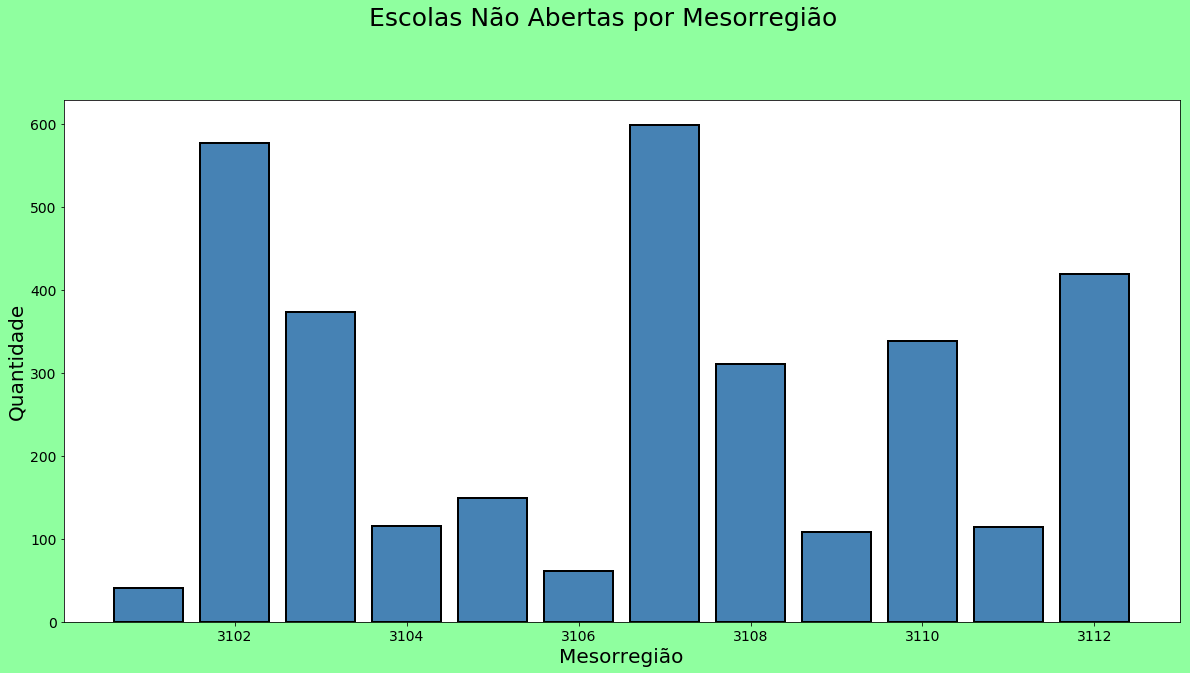

In [73]:
fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Escolas Não Abertas por Mesorregião", fontsize=25)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Mesorregião",fontsize=20)
ax.set_ylabel("Quantidade",fontsize=20) 
w_q = df['CO_MESORREGIAO'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=14)
bar = ax.bar(w_q[0], w_q[1], color='steelblue', 
        edgecolor='black', linewidth=2)

'''
Belo Horizonte	3101
Montes Claros	3102
Teófilo Otoni	3103
Governador Valadares	3104
Ipatinga	3105
Juiz de Fora	3106
Barbacena	3107
Varginha	3108
Pouso Alegre	3109
Uberaba	3110
Uberlândia	3111
Patos de Minas	3112
Divinópolis	3113
'''

In [85]:
##### Uma medida para Infraestrutura ###

df['infra'] = df.IN_AGUA_FILTRADA+df.IN_ENERGIA_REDE_PUBLICA+df.IN_ESGOTO_REDE_PUBLICA
+df.IN_LIXO_COLETA_PERIODICA+df.IN_LIXO_RECICLA+df.IN_SALA_DIRETORIA
+df.IN_SALA_PROFESSOR+df.IN_LABORATORIO_INFORMATICA+df.IN_LABORATORIO_CIENCIAS
+df.IN_SALA_ATENDIMENTO_ESPECIAL+df.IN_QUADRA_ESPORTES+df.IN_COZINHA+df.IN_BIBLIOTECA
+df.IN_SALA_LEITURA+df.IN_PARQUE_INFANTIL+df.IN_BERCARIO+df.IN_BANHEIRO_FORA_PREDIO
+df.IN_BANHEIRO_DENTRO_PREDIO+df.IN_BANHEIRO_EI+df.IN_BANHEIRO_PNE
+df.IN_DEPENDENCIAS_PNE


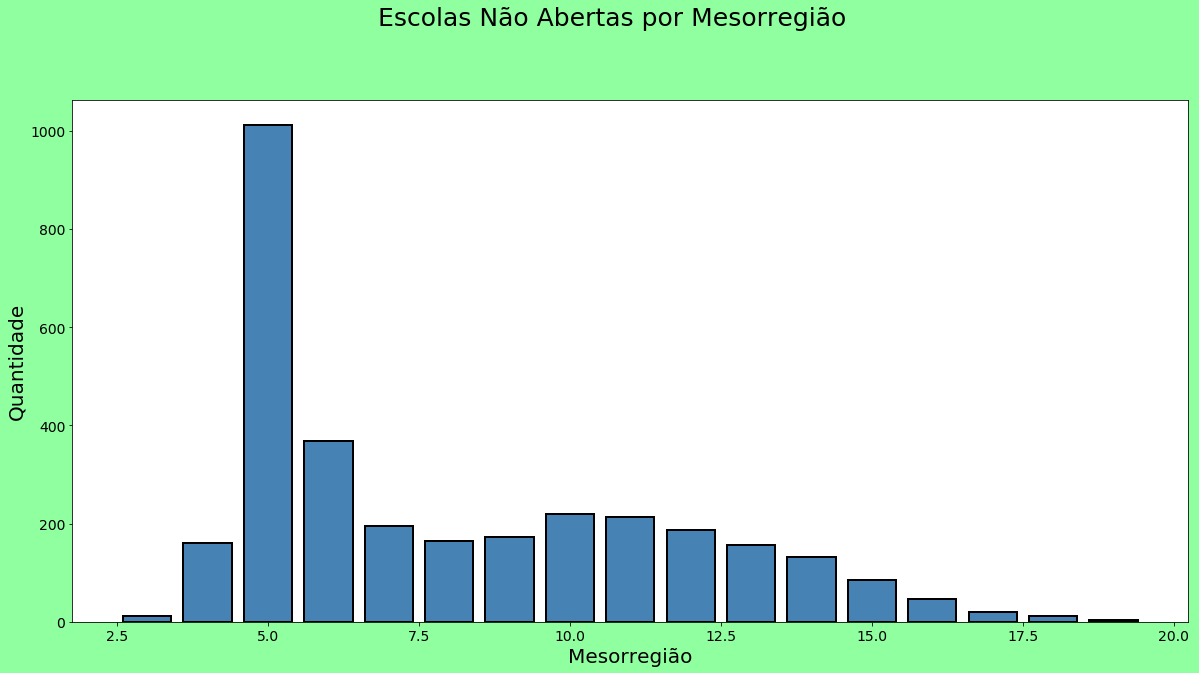

In [86]:
fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Infraestrura", fontsize=25)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Mesorregião",fontsize=20)
ax.set_ylabel("Quantidade",fontsize=20) 
w_q = df['infra'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=14)
bar = ax.bar(w_q[0], w_q[1], color='steelblue', 
        edgecolor='black', linewidth=2)